# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Цель

Построить модель, которая умеет определять рыночную стоимость автомобиля, основываясь на данных о технических характеристиках, комплектации и ценах других автомобилей.

### Задачи

1. Изучить данные и обраюотать данные
2. Подготовить выборки для обучения моделей
3. Обучить разные модели
4. Проанализировать время обучения, время предсказания и качество моделей
5. Опираясь на критерии заказчика, выбрать наилучшую модель


### Описание данных

**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder)
from sklearn.metrics import (mean_squared_error, make_scorer)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

Загрузим данные

In [18]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

Изучим данные

In [19]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [20]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])

Оставим только те признаки, которые помогут построить модель

In [21]:
df_preprocessed = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 
                           'PostalCode', 'NumberOfPictures', 'LastSeen'], axis=1)

In [22]:
df_preprocessed.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [23]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


**Проверим данные на наличие явных дубликатов**

In [24]:
df_preprocessed.duplicated().sum()

45040

Отбросим дубликаты

In [25]:
df_preprocessed = df_preprocessed.drop_duplicates()

**Обработаем пропуски**

Столбец `Model`

In [26]:
df_preprocessed['Model'].isna().sum()

18361

In [27]:
df_preprocessed['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [28]:
df_preprocessed[df_preprocessed['Model']=='other'].shape[0]

22934

Пропуски в данном столбце заполним заглушкой 'other'

In [29]:
df_preprocessed['Model'] = df_preprocessed['Model'].fillna('other')

In [30]:
df_preprocessed['Model'].isna().sum()

0

Столбец `VehicleType`

In [31]:
df_preprocessed['VehicleType'].isna().sum()

34559

Пропуски в данном столбце можно заменить самым часто встречающимся значением для данного бренда

In [32]:
VehicleType = df_preprocessed.pivot_table(
    index=['Brand'], columns=['VehicleType'], values=['Price'], aggfunc='count')

In [33]:
VehicleType.head()

Price                                                           
VehicleType    bus convertible   coupe  other    sedan   small    suv   wagon
Brand                                                                        
alfa_romeo     NaN       170.0   210.0   14.0    866.0   227.0    1.0   415.0
audi          10.0      1481.0  1353.0  101.0   9289.0  1333.0  116.0  9505.0
bmw            7.0      2930.0  3368.0  231.0  14682.0   419.0  670.0  6795.0
chevrolet    155.0        16.0    85.0   43.0    218.0   543.0  358.0   103.0
chrysler     413.0       221.0    43.0   10.0    274.0    11.0   23.0   226.0

In [34]:
VehicleType.columns = VehicleType.columns.droplevel(0)

In [35]:
VehicleType.columns.name = None

In [36]:
VehicleType.head()

,bus,convertible,coupe,other,sedan,small,suv,wagon
Brand,,,,,,,,
alfa_romeo,NaN,170.0,210.0,14.0,866.0,227.0,1.0,415.0
audi,10.0,1481.0,1353.0,101.0,9289.0,1333.0,116.0,9505.0
bmw,7.0,2930.0,3368.0,231.0,14682.0,419.0,670.0,6795.0
chevrolet,155.0,16.0,85.0,43.0,218.0,543.0,358.0,103.0
chrysler,413.0,221.0,43.0,10.0,274.0,11.0,23.0,226.0


In [37]:
VehicleType['Max'] = VehicleType[VehicleType.columns].idxmax(axis=1)

In [38]:
VT_dict = VehicleType['Max'].to_dict()

In [39]:
VT_dict

{'alfa_romeo': 'sedan',
 'audi': 'wagon',
 'bmw': 'sedan',
 'chevrolet': 'small',
 'chrysler': 'bus',
 'citroen': 'small',
 'dacia': 'wagon',
 'daewoo': 'small',
 'daihatsu': 'small',
 'fiat': 'small',
 'ford': 'small',
 'honda': 'sedan',
 'hyundai': 'small',
 'jaguar': 'sedan',
 'jeep': 'suv',
 'kia': 'suv',
 'lada': 'suv',
 'lancia': 'small',
 'land_rover': 'suv',
 'mazda': 'sedan',
 'mercedes_benz': 'sedan',
 'mini': 'small',
 'mitsubishi': 'sedan',
 'nissan': 'small',
 'opel': 'small',
 'peugeot': 'small',
 'porsche': 'convertible',
 'renault': 'small',
 'rover': 'sedan',
 'saab': 'sedan',
 'seat': 'small',
 'skoda': 'wagon',
 'smart': 'small',
 'sonstige_autos': 'sedan',
 'subaru': 'wagon',
 'suzuki': 'small',
 'toyota': 'small',
 'trabant': 'sedan',
 'volkswagen': 'sedan',
 'volvo': 'wagon'}

Теперь для каждой марки мы знаем наиболее типичную модель и можем заполнить пропуски в данных.


In [40]:
df_preprocessed['VehicleType'] = df_preprocessed['VehicleType'].fillna(
    df_preprocessed['Brand'].map(VT_dict))

In [41]:
df_preprocessed['VehicleType'].isna().sum()

0

Столбец `FuelType`

In [42]:
df_preprocessed['FuelType'].isna().sum()

30764

Заполним пропуски наиболее характерным видом топлива для данного типа кузова машины.

In [43]:
FuelType = df_preprocessed.pivot_table(
    index=['VehicleType'], columns=['FuelType'], values=['Price'], aggfunc='count')

In [44]:
FuelType.head()

Price                                                
FuelType       cng electric gasoline hybrid     lpg other   petrol
VehicleType                                                       
bus          215.0      1.0  15394.0    5.0   489.0   8.0   8787.0
convertible    3.0      6.0   1364.0    NaN   215.0   6.0  15771.0
coupe          3.0      6.0   1860.0   15.0   270.0   3.0  11729.0
other         12.0     12.0   1383.0    1.0    28.0  41.0   1343.0
sedan         56.0     11.0  23219.0  125.0  1683.0  71.0  57835.0

In [45]:
FuelType.columns = FuelType.columns.droplevel(0)

In [46]:
FuelType.columns.name = None

In [47]:
FuelType.head()

,cng,electric,gasoline,hybrid,lpg,other,petrol
VehicleType,,,,,,,
bus,215.0,1.0,15394.0,5.0,489.0,8.0,8787.0
convertible,3.0,6.0,1364.0,NaN,215.0,6.0,15771.0
coupe,3.0,6.0,1860.0,15.0,270.0,3.0,11729.0
other,12.0,12.0,1383.0,1.0,28.0,41.0,1343.0
sedan,56.0,11.0,23219.0,125.0,1683.0,71.0,57835.0


In [48]:
FuelType['Max'] = FuelType[FuelType.columns].idxmax(axis=1)

In [49]:
FT_dict = FuelType['Max'].to_dict()

In [50]:
FT_dict

{'bus': 'gasoline',
 'convertible': 'petrol',
 'coupe': 'petrol',
 'other': 'gasoline',
 'sedan': 'petrol',
 'small': 'petrol',
 'suv': 'gasoline',
 'wagon': 'gasoline'}

Теперь для каждого типа кузова мы знаем наиболее типичное топливо.


In [51]:
df_preprocessed['FuelType'] = df_preprocessed['FuelType'].fillna(
    df_preprocessed['VehicleType'].map(FT_dict))

In [52]:
df_preprocessed['FuelType'].isna().sum()

0

Столбец `Gearbox`

In [53]:
df_preprocessed['Gearbox'].isna().sum()

17207

In [54]:
df_preprocessed['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [55]:
df_preprocessed['Gearbox'].value_counts()

manual    232774
auto       59348
Name: Gearbox, dtype: int64

В датафрейме механическая коробка передач встречается в 4 раз чаще, чем автоматическая, поэтому пропуски следует заполнить значением 'manual'.

In [56]:
df_preprocessed['Gearbox'] = df_preprocessed['Gearbox'].fillna('manual')

In [57]:
df_preprocessed['Gearbox'].isna().sum()

0

Столбец `Repaired`

In [58]:
df_preprocessed['Repaired'].isna().sum()

64558

In [59]:
df_preprocessed['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [60]:
df_preprocessed['Repaired'].value_counts()

no     211328
yes     33443
Name: Repaired, dtype: int64

Заполним пропуски значением 'no'

In [61]:
df_preprocessed['Repaired'] = df_preprocessed['Repaired'].fillna('no')

In [62]:
df_preprocessed['Repaired'].isna().sum()

0

In [63]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             309329 non-null  int64 
 1   VehicleType       309329 non-null  object
 2   RegistrationYear  309329 non-null  int64 
 3   Gearbox           309329 non-null  object
 4   Power             309329 non-null  int64 
 5   Model             309329 non-null  object
 6   Kilometer         309329 non-null  int64 
 7   FuelType          309329 non-null  object
 8   Brand             309329 non-null  object
 9   Repaired          309329 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


Все пропуски обработаны.

**Обработаем аномалии в столбцах**

Столбец `Price`

In [64]:
%matplotlib inline

<AxesSubplot: >

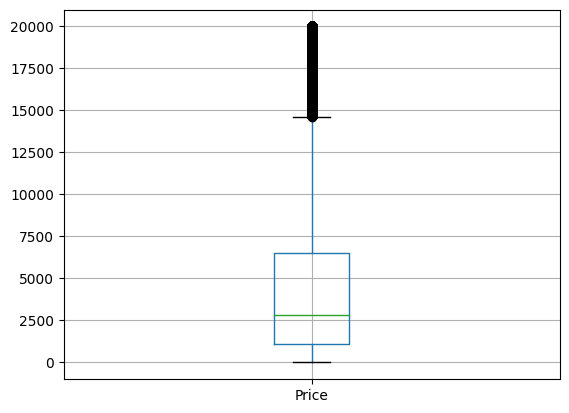

In [65]:
df_preprocessed.boxplot(column=['Price'])

Получаем, что в границы нормального размаха не входят цены больше примерно 15_000 евро. Будем считать эти значения выбросами.

<AxesSubplot: >

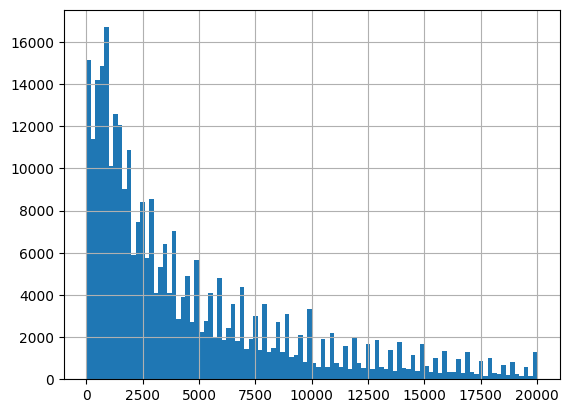

In [66]:
df_preprocessed['Price'].hist(bins=100)

На гистограмме видим большое количество объектов с нулевой ценой, что точно является аномалией. Будем считать машины дешевле 500 евро аномалиями.

Удалим аномальные значения

In [67]:
df_preprocessed = df_preprocessed.query('Price > 500 & Price < 15000')

In [68]:
df_preprocessed.shape[0]

258472

Стобец `RegistrationYear`

Уберем явные выбросы

In [69]:
sorted(df_preprocessed['RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1234,
 1400,
 1500,
 1600,
 1800,
 1910,
 1923,
 1925,
 1928,
 1929,
 1930,
 1931,
 1932,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 4000,
 4100,
 4500,
 5000,
 5300,
 5555,
 5911,
 6000,
 7000,
 7100,
 7800,
 8500,
 8888,
 9000,
 9450,
 9999]

In [70]:
df_preprocessed = df_preprocessed.query('RegistrationYear > 1900 & RegistrationYear < 2025')

<AxesSubplot: >

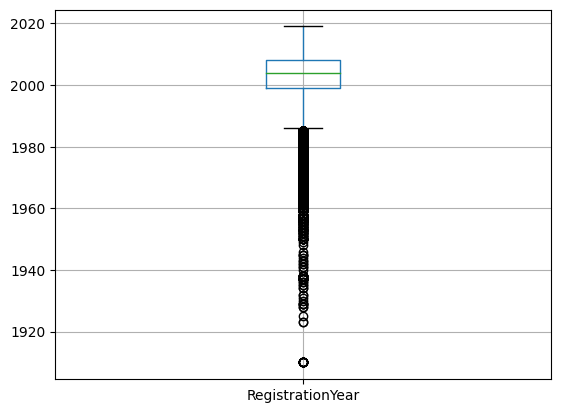

In [71]:
df_preprocessed.boxplot(column=['RegistrationYear'])

Выбросами будем считать машины, зарегистрированные до 1990 г.

In [72]:
df_preprocessed = df_preprocessed.query('RegistrationYear > 1990')

В верхней части графика также наблюдаем выбросы. Проверим согласованность дат скачивания и регистрации анкеты с датой регистрации автомобиля.

In [73]:
max(df["DateCrawled"].apply(lambda x: x.year))

2016

In [74]:
min(df['DateCrawled'].apply(lambda x: x.year))

2016

In [75]:
max(df['DateCreated'].apply(lambda x: x.year))

2016

In [76]:
min(df['DateCreated'].apply(lambda x: x.year))

2014

Как видим, данные были созданы и обработаны не позднее 2016 г., поэтому автомобили, зарегистрированные после 2016 г. будем считать аномалией.

In [77]:
df_preprocessed.shape[0]

249430

Столбец `Power`

In [78]:
sorted(df_preprocessed['Power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186

Уберем явные выбросы

In [79]:
df_preprocessed = df_preprocessed.query('Power < 500')

In [80]:
df_preprocessed.shape[0]

249111

<AxesSubplot: >

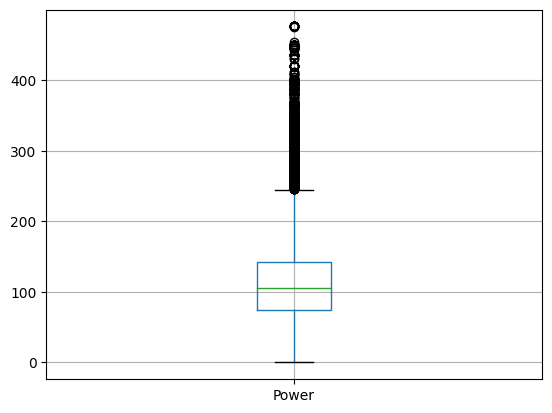

In [81]:
df_preprocessed.boxplot(column=['Power'])

Уберем значения, выходящие за верхний ус, и значения, меньшие 50 л.с.

In [82]:
df_preprocessed = df_preprocessed.query('Power < 250 & Power > 50')

<AxesSubplot: >

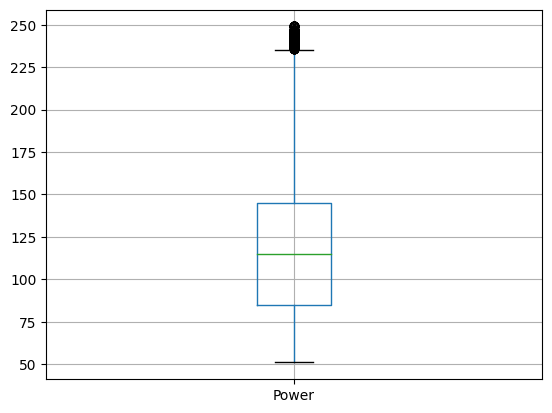

In [83]:
df_preprocessed.boxplot(column=['Power'])

In [84]:
df_preprocessed.shape[0]

216635

Столбец `Kilometer`

<AxesSubplot: >

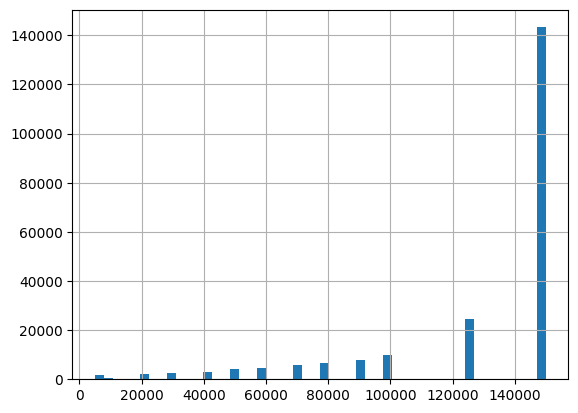

In [85]:
df_preprocessed['Kilometer'].hist(bins=50)

<AxesSubplot: >

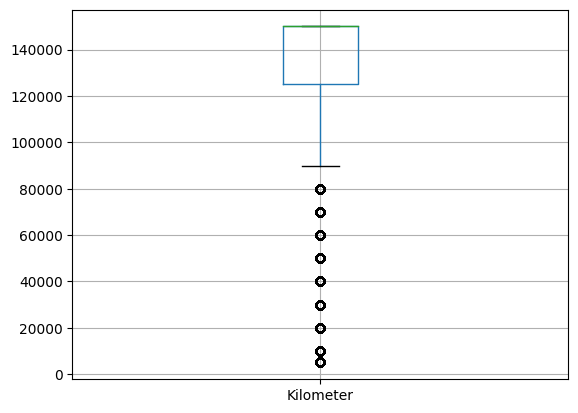

In [86]:
df_preprocessed.boxplot(column=['Kilometer'])

In [87]:
df_preprocessed['Kilometer'].value_counts()

150000    143274
125000     24562
100000      9686
90000       7792
80000       6754
70000       5831
60000       4782
50000       4028
40000       3010
30000       2521
20000       2089
5000        1796
10000        510
Name: Kilometer, dtype: int64

Cудя по представленным значениям, в анкете можно выбрать конкертный диапазон, в который укладывается пробег автомобиля.

Выбросами будем считать пробег, не укладывающийся в стандартный размах, т.е. меньший 90 000 км.

In [88]:
df_preprocessed = df_preprocessed.query('Kilometer >= 90000')

In [89]:
df_preprocessed.shape[0]

185314

In [90]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185314 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             185314 non-null  int64 
 1   VehicleType       185314 non-null  object
 2   RegistrationYear  185314 non-null  int64 
 3   Gearbox           185314 non-null  object
 4   Power             185314 non-null  int64 
 5   Model             185314 non-null  object
 6   Kilometer         185314 non-null  int64 
 7   FuelType          185314 non-null  object
 8   Brand             185314 non-null  object
 9   Repaired          185314 non-null  object
dtypes: int64(4), object(6)
memory usage: 15.6+ MB


**Подготовим выборки для моделей**

In [91]:
features = df_preprocessed.drop('Price', axis=1)
target = df_preprocessed['Price']

In [92]:
features_train, features_tmp, target_train, target_tmp = train_test_split(
    features, target, test_size=0.4, random_state=12345) #0.6 данных уходят в обучающую выборку, еще 0.4 
#мы дальше поделим на тестовую и валидационную по 0.2 данных в каждой

In [93]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_tmp, target_tmp, test_size=0.5, random_state=12345) #Получаем тестовую и валидационную выборки

**Масштабируем количественные признаки**

In [94]:
# создаём скелер
scaler = StandardScaler()

In [95]:
features_train.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

Набор признаков, подлежащих масштабированию

In [96]:
sc_features = ['RegistrationYear', 'Power', 'Kilometer']

In [97]:
# обучаем скелер на численных признаках тренировочной выборки
scaler.fit(features_train[sc_features])

StandardScaler()

In [98]:
# трансформируем её же
features_train[sc_features] = scaler.transform(features_train[sc_features])

In [99]:
#трансформируем тестовую выборку
features_test[sc_features] = scaler.transform(features_test[sc_features])

In [100]:
#трансформируем валидационную выборку
features_valid[sc_features] = scaler.transform(features_valid[sc_features])

In [101]:
features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
137035,sedan,0.814698,manual,1.118056,3er,0.494207,petrol,bmw,no
273084,small,0.994938,manual,-1.431462,punto,-0.962446,cng,fiat,no
101256,bus,1.175179,manual,-0.179881,other,-0.962446,gasoline,renault,no
297591,sedan,2.256623,manual,1.627959,3er,0.494207,petrol,bmw,no
20014,small,0.273976,manual,-1.431462,ka,-0.962446,petrol,ford,no


**Выполним кодирование категориальных признаков**

Для модели регрессии случайного леса выберем порядковое кодирование.

In [102]:
#категориальные признаки для OrdinalEncoding
ordinal_features = features_train.select_dtypes(include='object').columns.to_list()
ordinal_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [103]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [104]:
# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ordinal.fit(features_train[ordinal_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [105]:
# Создадим копии выборок для порядкового кодирования
features_train_ordinal = features_train.copy()
features_test_ordinal = features_test.copy()
features_valid_ordinal = features_valid.copy()


In [106]:
# добавляем закодированные признаки
features_train_ordinal[ordinal_features] = encoder_ordinal.transform(features_train_ordinal[ordinal_features])
features_test_ordinal[ordinal_features] = encoder_ordinal.transform(features_test_ordinal[ordinal_features])
features_valid_ordinal[ordinal_features] = encoder_ordinal.transform(features_valid_ordinal[ordinal_features])

In [107]:
features_test_ordinal.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
137035,4.0,0.814698,1.0,1.118056,11.0,0.494207,6.0,2.0,0.0
273084,5.0,0.994938,1.0,-1.431462,172.0,-0.962446,0.0,9.0,0.0
101256,0.0,1.175179,1.0,-0.179881,162.0,-0.962446,2.0,27.0,0.0
297591,4.0,2.256623,1.0,1.627959,11.0,0.494207,6.0,2.0,0.0
20014,5.0,0.273976,1.0,-1.431462,125.0,-0.962446,6.0,10.0,0.0


Для моделей бустинга и линейной регрессии используем ohe.

In [108]:
#категориальные признаки для OHE 
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [109]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [110]:
# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [111]:
# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features]);

In [112]:
# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

In [113]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1);

In [114]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем валидационную
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1);

In [115]:
# получилось одинаковое количество признаков
features_train.shape,  features_test.shape, features_valid.shape

((111188, 295), (37063, 295), (37063, 295))

In [116]:
# получились одинаковые признаки 
((features_train.columns != features_test.columns) | 
 (features_valid.columns != features_test.columns)).sum()

0

Результат кодирования и масштабирования

In [117]:
features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,Repaired_yes
107360,-0.807468,-0.272590,0.494207,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
90569,-1.528430,0.422733,0.494207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249190,0.994938,1.280298,-0.962446,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312727,-0.266746,-1.315575,0.494207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93278,-0.807468,-1.431462,0.494207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение моделей

In [118]:
# Метрика качества
def rmse(y_true,y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [119]:
# Создадим scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

**Градиентный бустинг с момощью LightGBM**

In [120]:
#Создаем модель регрессии
lgb_booster = lgb.LGBMModel(objective='regression', random_state=12345)

Создаем GridSearchCV объект

In [121]:
GS_lgb = GridSearchCV(estimator = lgb_booster,
                  param_grid = {'num_leaves':[x for x in range(10, 40, 10)],
                                'learning_rate':[0.05, 0.1, 0.15, 0.2],
                                'n_estimators':[x for x in range(80, 120, 10)]},
                  scoring = rmse_scorer,
                  cv=2)

In [122]:
%%time
GS_lgb.fit(features_train, target_train)

CPU times: total: 6min 15s
Wall time: 1min 10s


GridSearchCV(cv=2,
             estimator=LGBMModel(objective='regression', random_state=12345),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [80, 90, 100, 110],
                         'num_leaves': [10, 20, 30]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [123]:
GS_lgb.best_score_ # Лучшее значение rmse для lgb_booster

-1350.8787715551696

In [124]:
lgb_best = GS_lgb.best_estimator_

In [125]:
%%time
lgb_best.fit(features_train, target_train)

CPU times: total: 3.56 s
Wall time: 774 ms


LGBMModel(learning_rate=0.2, n_estimators=110, num_leaves=30,
          objective='regression', random_state=12345)

In [126]:
%%time
lgb_predictions = lgb_best.predict(features_valid)

CPU times: total: 688 ms
Wall time: 252 ms


In [127]:
# rmse по валидационной выборке
rmse(target_valid, lgb_predictions)

1344.6108255454965

**Градиентный бустинг с момощью CatBoost**

In [128]:
#Создаем модель регрессии
cat_booster = CatBoostRegressor(random_state=12345)

In [129]:
# Создаем GridSearchCV объект
GS_cat = GridSearchCV(estimator = cat_booster,
                  param_grid = {'learning_rate':[0.05, 0.1, 0.15, 0.2],
                                'n_estimators':[x for x in range(80, 120, 10)]},
                  scoring = rmse_scorer,
                  cv=2)

In [130]:
%%time
GS_cat.fit(features_train, target_train)

0:	learn: 3243.5167536	total: 160ms	remaining: 12.6s
1:	learn: 3147.9081314	total: 169ms	remaining: 6.61s
2:	learn: 3059.0489380	total: 179ms	remaining: 4.59s
3:	learn: 2976.7337065	total: 188ms	remaining: 3.56s
4:	learn: 2897.1317910	total: 197ms	remaining: 2.96s
5:	learn: 2821.2427761	total: 206ms	remaining: 2.54s
6:	learn: 2750.8768325	total: 215ms	remaining: 2.24s
7:	learn: 2686.8461466	total: 223ms	remaining: 2s
8:	learn: 2625.7945187	total: 232ms	remaining: 1.83s
9:	learn: 2568.8673303	total: 240ms	remaining: 1.68s
10:	learn: 2513.4495858	total: 250ms	remaining: 1.57s
11:	learn: 2462.2239096	total: 258ms	remaining: 1.46s
12:	learn: 2409.8562734	total: 267ms	remaining: 1.37s
13:	learn: 2365.0943044	total: 276ms	remaining: 1.3s
14:	learn: 2320.3737021	total: 285ms	remaining: 1.23s
15:	learn: 2279.7404209	total: 294ms	remaining: 1.18s
16:	learn: 2241.0140207	total: 303ms	remaining: 1.12s
17:	learn: 2203.3676450	total: 313ms	remaining: 1.08s
18:	learn: 2169.4400668	total: 322ms	remai

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000018D33A7E730>,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [80, 90, 100, 110]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [131]:
GS_cat.best_score_ # Лучшее значение rmse для lgb_booster

-1395.66981957721

In [132]:
GS_cat_best = GS_cat.best_estimator_

In [133]:
%%time
GS_cat_best.fit(features_train, target_train)

0:	learn: 2945.2697436	total: 15.5ms	remaining: 1.69s
1:	learn: 2641.1470541	total: 30.1ms	remaining: 1.63s
2:	learn: 2410.9032115	total: 44.5ms	remaining: 1.59s
3:	learn: 2243.0448954	total: 58.3ms	remaining: 1.54s
4:	learn: 2101.7883501	total: 70.8ms	remaining: 1.49s
5:	learn: 2010.1351266	total: 83.6ms	remaining: 1.45s
6:	learn: 1922.4252539	total: 97.1ms	remaining: 1.43s
7:	learn: 1859.7170793	total: 110ms	remaining: 1.4s
8:	learn: 1805.5999039	total: 123ms	remaining: 1.38s
9:	learn: 1754.3880427	total: 136ms	remaining: 1.36s
10:	learn: 1715.3107991	total: 150ms	remaining: 1.35s
11:	learn: 1686.3760097	total: 163ms	remaining: 1.33s
12:	learn: 1662.6877139	total: 175ms	remaining: 1.3s
13:	learn: 1638.4548473	total: 189ms	remaining: 1.29s
14:	learn: 1618.6632280	total: 201ms	remaining: 1.27s
15:	learn: 1603.7324286	total: 216ms	remaining: 1.27s
16:	learn: 1588.6602591	total: 232ms	remaining: 1.27s
17:	learn: 1576.2269634	total: 251ms	remaining: 1.28s
18:	learn: 1568.8370728	total: 26

In [134]:
%%time
cat_predictions = GS_cat_best.predict(features_valid)

CPU times: total: 203 ms
Wall time: 166 ms


In [135]:
# rmse по валидационной выборке
rmse(target_valid, cat_predictions)

1396.7925732917204

**Модель регрессии случайного леса**

In [136]:
forest_model = RandomForestRegressor(random_state=12345)

Создаем GridSearchCV объект

In [137]:
#x for x in range(10, 60, 10)
GS_forest = GridSearchCV(estimator = forest_model,
                  param_grid = {'max_depth':[5],
                  'n_estimators':[10, 20, 30]},
                  scoring = rmse_scorer,
                  cv=2
                  )

In [138]:
%%time
GS_forest.fit(features_train_ordinal, target_train)

CPU times: total: 5.73 s
Wall time: 5.92 s


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5], 'n_estimators': [10, 20, 30]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [139]:
GS_forest.best_score_ # Лучшее значение rmse для lgb_booster

-1881.5332996854654

In [140]:
GS_forest_best = GS_forest.best_estimator_

In [141]:
%%time
GS_forest_best.fit(features_train_ordinal, target_train)

CPU times: total: 953 ms
Wall time: 980 ms


RandomForestRegressor(max_depth=5, n_estimators=10, random_state=12345)

In [142]:
%%time
forest_predictions = GS_forest_best.predict(features_valid_ordinal)

CPU times: total: 46.9 ms
Wall time: 34.2 ms


In [143]:
# rmse по валидационной выборке
rmse(target_valid, forest_predictions)

1916.1676231448528

**Модель линейной регрессии**

In [144]:
linear_model = LinearRegression()

In [145]:
%%time
linear_model.fit(features_train, target_train)

CPU times: total: 13.4 s
Wall time: 5.07 s


LinearRegression()

In [146]:
%%time
linear_predictions = linear_model.predict(features_valid)

CPU times: total: 203 ms
Wall time: 124 ms


In [147]:
# rmse по валидационной выборке
rmse(target_valid, linear_predictions)

2030.9733892885113

## Анализ моделей

**Результат для LightGBM**

Время обучения: 793 ms

Время предсказания: 226 ms

RMSE: 1345

**Результаты для CatBoost**

Время обучения: 1.84 s

Время предсказания: 40 ms

RMSE: 1397

**Результаты для RandomForestRegressor**

Время обучения: 906 ms

Время предсказания: 32 ms

RMSE: 1916

**Результаты для LinearRegression**

Время обучения: 3.52 s

Время предсказания: 123 ms

RMSE: 2031

**Лучшая модель**

Модель LightGBM существенно превосходит другие модели по качеству предсказаний и скорости обучения, поэтому выберем ее как основную.  

## Тестирование

In [148]:
%%time
lgb_test_predictions = lgb_best.predict(features_test)

CPU times: total: 844 ms
Wall time: 313 ms


In [149]:
# rmse по валидационной выборке
rmse(target_test, lgb_test_predictions)

1332.236090654697

Качество предсказания на тестовой выборке даже немного улучшилось

**Сравним модель с константной**

In [150]:
dummy_regr = DummyRegressor(strategy="median")

In [151]:
%%time
dummy_regr.fit(features_train, target_train)

CPU times: total: 0 ns
Wall time: 3 ms


DummyRegressor(strategy='median')

In [152]:
%%time
dummy_predictions = dummy_regr.predict(features_test)

CPU times: total: 0 ns
Wall time: 1e+03 µs


In [153]:
# rmse по валидационной выборке
rmse(target_valid, dummy_predictions)

3527.0208481441764

Модель прошла проверку на адекватность

## Вывод

Целью данного проекта было создание модели, предсказывающей рыночную стоимость автомобиля по его характеристикам. Заказчику были важны качество предсказания, время обучения и время предсказания модели. Для оценки качества моделей использовалась RMSE. 

В ходе предобработки были ликвидированы пропуски в данных, аномальные и неинформативные данные были удалены. 

В ходе исследования были рассмотрены 4 модели: 
* линейная регрессия;
* регрессия случайного леса;
* регрессия LightGBM;
* регрессия CatBoost.

Наилучшие результаты по времени обучения и качеству предсказания показала модель градиентного бустинга LightGBM, которая и была выбрана в качестве основной.

На тестовой выборке модель регрессии LightGBM показала следующие результаты:
* Время обучения: 1.08 s;
* Время предсказания: 588 ms;
* RMSE: 1332.